In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split


POI_FILENAME = "../data/poi-paris.pkl"
parismap = mpimg.imread('../data/paris-48.806-2.23--48.916-2.48.jpg')
## coordonnees GPS de la carte
xmin, xmax = 2.23, 2.48  # coord_x min et max
ymin, ymax = 48.806, 48.916  # coord_y min et max
coords = [xmin, xmax, ymin, ymax]


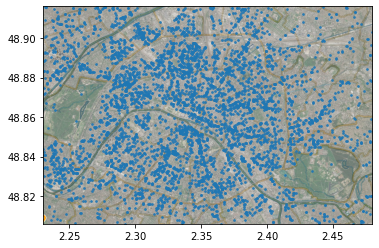

In [2]:
def get_density2D(f,data,steps=100):
    """ Calcule la densité en chaque case d'une grille steps x steps dont les bornes sont calculées à partir du min/max de data. Renvoie la grille estimée et la discrétisation sur chaque axe.
    """
    xmin, xmax = data[:,0].min(), data[:,0].max()
    ymin, ymax = data[:,1].min(), data[:,1].max()
    xlin,ylin = np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps)
    xx, yy = np.meshgrid(xlin,ylin)
    grid = np.c_[xx.ravel(), yy.ravel()]
    res = f.predict(grid).reshape(steps, steps)
    return res, xlin, ylin

def show_density(f, data, steps=100, log=False):
    """ Dessine la densité f et ses courbes de niveau sur une grille 2D calculée à partir de data, avec un pas de discrétisation de steps. Le paramètre log permet d'afficher la log densité plutôt que la densité brute
    """
    res, xlin, ylin = get_density2D(f, data, steps)
    xx, yy = np.meshgrid(xlin, ylin)
    plt.figure()
    show_img()
    if log:
        res = np.log(res+1e-10)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.8, s=3)
    show_img(res)
    plt.colorbar()
    plt.contour(xx, yy, res, 20)


def show_img(img=parismap):
    """ Affiche une matrice ou une image selon les coordonnées de la carte de Paris.
    """
    origin = "lower" if len(img.shape) == 2 else "upper"
    alpha = 0.3 if len(img.shape) == 2 else 1.
    plt.imshow(img, extent=coords, aspect=1.5, origin=origin, alpha=alpha)
    ## extent pour controler l'echelle du plan


def load_poi(typepoi,fn=POI_FILENAME):
    """ Dictionaire POI, clé : type de POI, valeur : dictionnaire des POIs de ce type : (id_POI, [coordonnées, note, nom, type, prix])
    
    Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, 
    clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
    """
    poidata = pickle.load(open(fn, "rb"))
    data = np.array([[v[1][0][1],v[1][0][0]] for v in sorted(poidata[typepoi].items())])
    note = np.array([v[1][1] for v in sorted(poidata[typepoi].items())])
    return data,note
    

plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)



# Creation des classes

In [3]:
class Density(object):
    def fit(self,data):
        pass
    def predict(self,data):
        pass
    def score(self,data):
        #A compléter : retourne la log-vraisemblance
        eps = 10e-10
        density = self.predict(data) + eps
        return np.sum(np.log(density))/data.shape[0]
        # on utilise 10-10 comme epsilon pour le ne pas avoir de valeur à 0 ce qui passé au log serait égal à 1 
    
class Histogramme(Density):
    def __init__(self,steps=10):
        Density.__init__(self)
        self.steps = steps                       # pas de l'histogramme
        
    def fit(self,x):
        self.histo, _ = np.histogramdd(x,bins=self.steps)    # fonction préimplémentée pour calculer l'histogramme
    
    def to_bin(self,x):
        n = x.shape[0]                           # nb d'exemple
        xmin, xmax = x[:,0].min(), x[:,0].max()  # definir les bornes min et max sur les 2 axes
        ymin, ymax = x[:,1].min(), x[:,1].max()
        delta_x = (xmax-xmin)/self.steps         # definir les bins
        delta_y = (ymax-ymin)/self.steps
        
        indices = []
        for i in range(n):
            xi = int((x[i,0]-xmin)/delta_x)      # classer les point dans les bons bins
            yi = int((x[i,1]-ymin)/delta_y)
            if xi == self.steps:                 # si on tombe sur une borne de l'histo
                xi -= 1
            if yi == self.steps:
                yi -= 1
            indices.append((xi,yi))
        return indices,delta_x,delta_y
    
    def predict(self,x):
        n = x.shape[0]
        indices, delta_x, delta_y = self.to_bin(x)      
        taille = delta_x * delta_y
        result = np.zeros((n))
        for i in range(n):
            result[i] = self.histo[indices[i][0],indices[i][1]]/ taille*n   #densité associée à chaque point de x
        return result
    
    
# les noyaux utilisés pour les kernels gaussiens et uniforme ne sont pas les mêmes que ceux utilisés pour nadaraya
# car j'ai eu des problèmes de formats de matrices
       
def noyau_gaussien(x):   
    d = x.shape[0]
    return np.exp(-0.5 * np.linalg.norm(x, axis=1)**2) * (2*np.pi)**(-d/2) # application de la formule


def noyau_uniform(x):
    masque = (np.abs(x) < 0.5).all(axis=1)    #si x-xi/sigma <0.5 alors codé 1 sinon 0  
    return np.where(masque, 1, 0)


class KernelDensity(Density):
    def __init__(self, kernel=None, sigma=0.1):
        Density.__init__(self)
        self.kernel = kernel
        self.sigma = sigma

    def fit(self, x):
        self.x = x

    def predict(self, data):
        n, d = self.x.shape
        densite = []
        for x_i in data:
            xi = np.vstack([x_i]*n)             # adapté la forme pour la soustraction
            somme = self.kernel((xi - self.x)/self.sigma).sum()   #somme des noyaux appliqués à chaque point
            densite.append(somme / (n*self.sigma**d))        # normalisation
        return np.array(densite)
    

# Nadaraya

def uni(x, data, sigma): 
    data_kernel = (x-data)/sigma
    result = np.zeros(np.shape(data)[0])
    masque = np.where(np.abs(np.max(data_kernel, axis=1)) <= 0.5)
    result[masque] = 1
    return result

def gaussian(x, data, sigma):
    n, d = np.shape(data)
    data_kernel = (data-x)/sigma
    norm = np.linalg.norm(data_kernel, axis=1)
    res = np.exp((-0.5*np.square(norm))*((2*np.pi)**(d/2)))
    return res

# Implémentation de l'estimateur de Nadaraya
class Nadaraya:
    def __init__(self, kernel=gaussian, sigma=1):
        self.X_train = None
        self.y_train = None
        self.kernel = kernel
        self.sigma = sigma
        
    def fit(self, X_train, y_train):
        self.X_train = X_train       #data
        self.y_train = y_train       #label

    def predict(self, x):
        num = []
        denom=[]
        for x_elem in x:
            kernels = self.kernel(x_elem, self.X_train, self.sigma)
            num.append(np.dot(self.y_train.T, kernels))
            denom.append(kernels.sum())
        # problème de données Nan ou division par 0 donc transformation
        num = np.nan_to_num(np.array(num), copy=True, nan=1-10, posinf=-sys.maxsize, neginf=-sys.maxsize) 
        denom = np.nan_to_num(np.array(denom), copy=True, nan=1e-10, posinf=sys.maxsize, neginf=-sys.maxsize) 
        denom = np.where(denom ==0,1e-10,denom)
        solution = num/denom        
        return solution

def error(res,y_test):
    return ((res-y_test)**2).sum()   # moindre carré

# AFFICHAGE HISTOGRAMME

# Bar

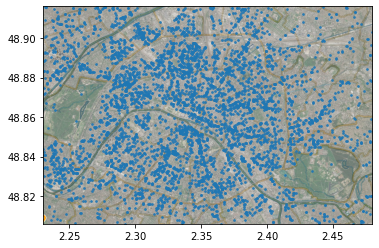

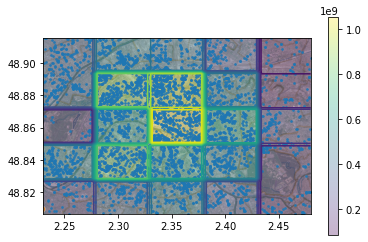

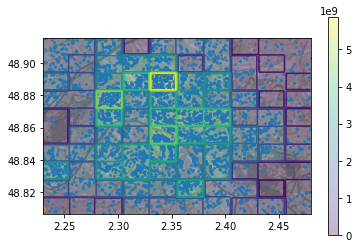

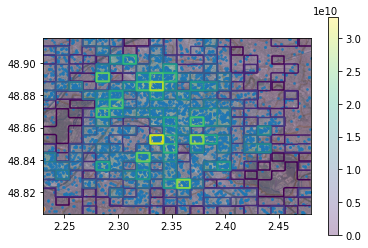

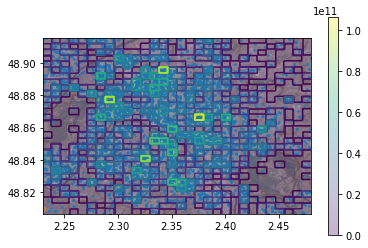

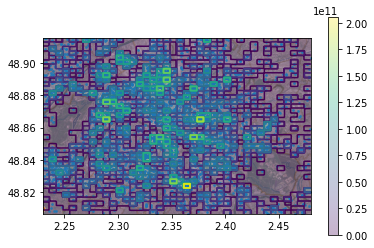

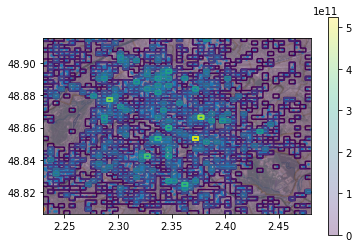

meilleur steps: 13, meilleur score: 19.046773835567645


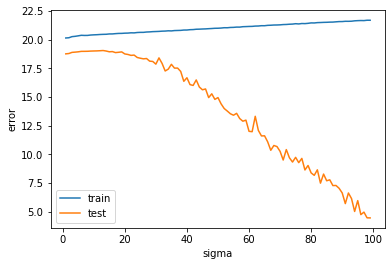

In [4]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.show()
plt.close()

for s in [5,10,20,30,40,50]:
    f = Histogramme(steps=s)
    f.fit(geo_mat)
    show_density(f,geo_mat,steps=f.steps*10)
    plt.show()
    plt.close()
    
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)
steps = np.arange(1,100)
best_steps = 0
best_score = -np.inf
scores_train = []
scores_test = []
for s in steps:
    f = Histogramme(steps=s)
    f.fit(geo_train)
    f_train = f.score(geo_train)
    f_test = f.score(geo_test)
    scores_train.append(f_train)
    scores_test.append(f_test)
    if best_score < f_test:
        best_score = f_test
        best_steps = s
print(f'meilleur steps: {best_steps}, meilleur score: {best_score}')

plt.plot(steps,scores_train,label ='train')
plt.plot(steps,scores_test,label='test')
plt.xlabel('sigma')
plt.ylabel('error')
plt.legend()
plt.show()

# Night_club

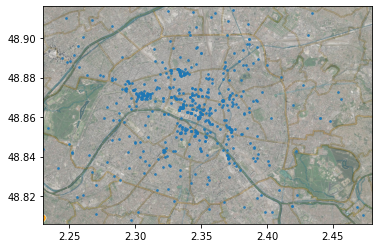

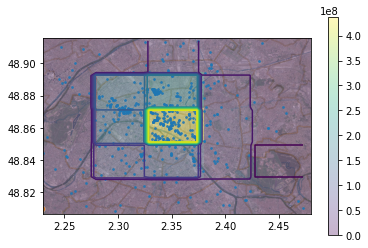

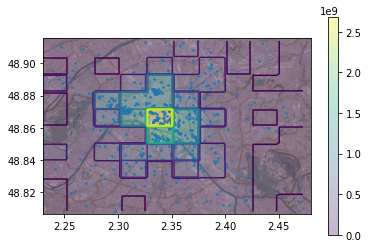

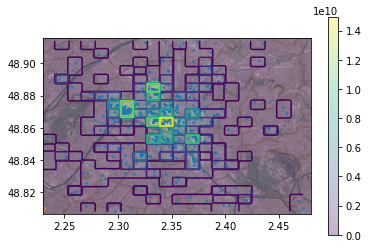

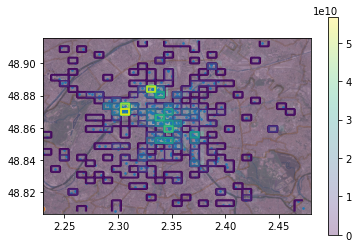

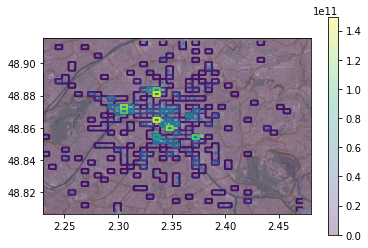

meilleur steps: 4, meilleur score: 15.215156553949043


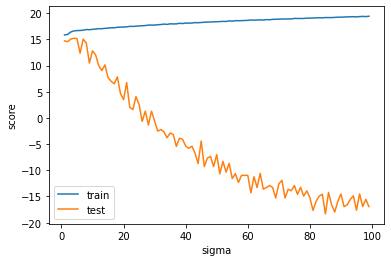

In [5]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.show()
plt.close()

for s in [5,10,20,30,40]:
    f = Histogramme(steps=s)
    f.fit(geo_mat)
    show_density(f,geo_mat,steps=f.steps*10)
    plt.show()
    plt.close()
    
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)
steps = np.arange(1,100)
best_steps = 0
best_score = -np.inf
scores_train = []
scores_test = []
for s in steps:
    f = Histogramme(steps=s)
    f.fit(geo_train)
    f_train = f.score(geo_train)
    f_test = f.score(geo_test)
    scores_train.append(f_train)
    scores_test.append(f_test)
    if best_score < f_test:
        best_score = f_test
        best_steps = s
print(f'meilleur steps: {best_steps}, meilleur score: {best_score}')

plt.plot(steps,scores_train,label= 'train')
plt.plot(steps,scores_test,label = 'test')
plt.xlabel('sigma')
plt.ylabel('score')
plt.legend()
plt.show()

Il y a moins d'individu dans l'echantillon boite de nuit que bar.
Pour bar le meilleur steps est 13 contre 4 pour boite de nuit 

# AFFICHAGE KERNEL

# Kernel uniforme

/tmp/ipykernel_30742/3781231601.py:24: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, res, 20)


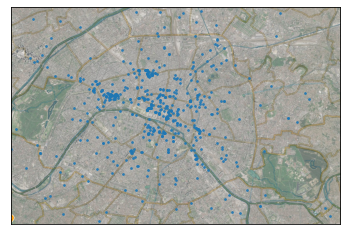

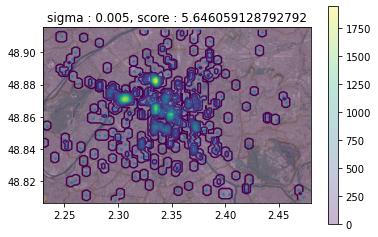

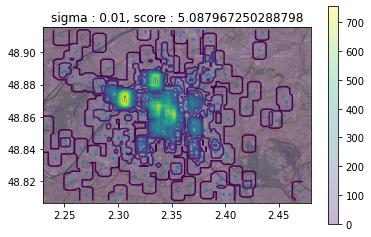

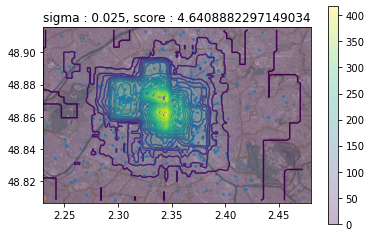

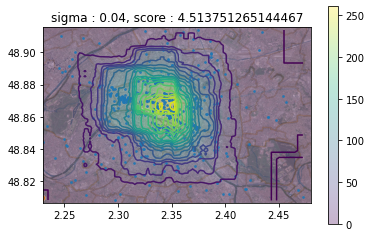

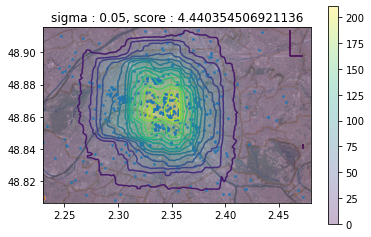

In [6]:
geo_mat, notes = load_poi("night_club")

# Affiche la carte de Paris
show_img()
# Affiche les POIs
plt.scatter(geo_mat[:,0],geo_mat[:,1],alpha=0.8,s=3)
plt.xticks([])
plt.yticks([])

for s in [0.005,0.01, 0.025,0.04, 0.05,1]:
    K = KernelDensity(kernel=noyau_uniform, sigma=s)
    K.fit(geo_mat)
    show_density(K, geo_mat)
    plt.gca().set_title(f'sigma : {s}, score : {K.score(geo_mat)}')
plt.close()

meilleur steps: 0.03, meilleur score: 4.637446713025691


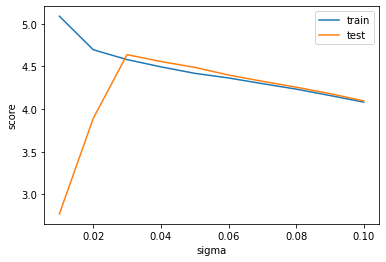

In [7]:
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)
sig=[0.01, 0.02,0.03, 0.04,0.05, 0.06,0.07, 0.08,0.09,0.1]
best_steps = 0
best_score = -np.inf
scores_train = []
scores_test = []
for s in sig:
    f = KernelDensity(kernel=noyau_uniform, sigma=s)
    f.fit(geo_train)
    f_train = f.score(geo_train)
    f_test = f.score(geo_test)
    scores_train.append(f_train)
    scores_test.append(f_test)
    if best_score < f_test:
        best_score = f_test
        best_sig = s
print(f'meilleur steps: {best_sig}, meilleur score: {best_score}')

plt.plot(sig,scores_train,label='train')
plt.plot(sig,scores_test,label='test')
plt.xlabel('sigma')
plt.ylabel('score')
plt.legend()
plt.show()

# Kernel gaussien

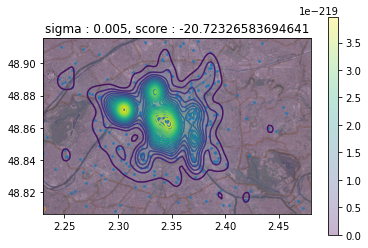

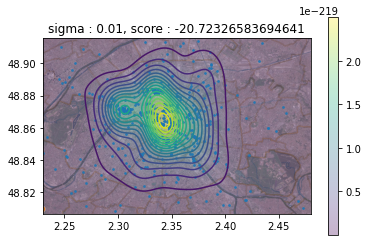

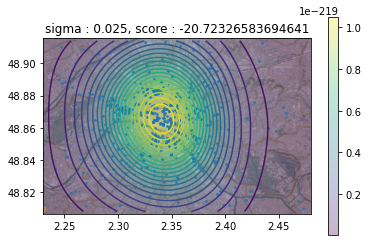

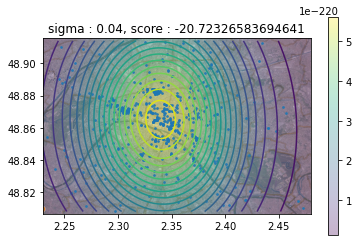

In [8]:
for sigma in [0.005,0.01, 0.025,0.04, 0.05]:
    K = KernelDensity(kernel=noyau_gaussien, sigma=sigma)
    K.fit(geo_mat)
    show_density(K, geo_mat)
    plt.gca().set_title(f'sigma : {sigma}, score : {K.score(geo_mat)}')

plt.close()  

meilleur steps: 5e-06, meilleur score: -20.723265836946414


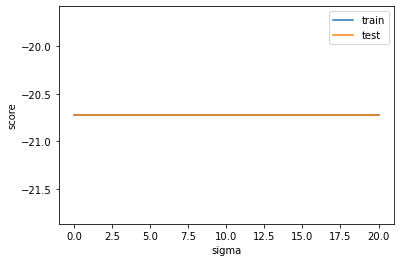

In [9]:
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)

sig = [0.000005,0.005,0.01, 0.025,0.04, 0.05,20]
best_steps = 0
best_score = -np.inf
scores_train = []
scores_test = []
for s in sig:
    if float(s):
        f = KernelDensity(kernel=noyau_gaussien, sigma=s)
        f.fit(geo_train)
        f_train = f.score(geo_train)
        f_test = f.score(geo_test)
        scores_train.append(f_train)
        scores_test.append(f_test)
        if best_score < f_test:
            best_score = f_test
            best_sig = s
print(f'meilleur steps: {best_sig}, meilleur score: {best_score}')


plt.plot(sig,scores_train,label='train')
plt.plot(sig,scores_test,label='test')
plt.xlabel('sigma')
plt.ylabel('score')
plt.legend()

# probleme sur le score avec noyau gaussien j'arrive pas à la debugger

In [10]:
import sys

In [11]:
plt.ion()
# Liste des POIs : furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
# La fonction charge la localisation des POIs dans geo_mat et leur note.
geo_mat, notes = load_poi("bar")
 
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)
f = Nadaraya(kernel=gaussian, sigma=0.005)
f.fit(geo_train,notes_train)
pred = np.array(f.predict(geo_test))
print(f'prediction : {np.round(pred[0:10],1)}')
print(f'notes : {notes_test[0:10]}')
print(f'erreur : {error(pred,notes_test)}')


prediction : [3.  1.9 3.6 3.3 3.4 1.5 3.9 3.6 3.2 3.1]
notes : [ 3.   4.2  4.7 -1.   4.   4.   4.   3.4  4.5  4.5]
erreur : 3832.1360205245264


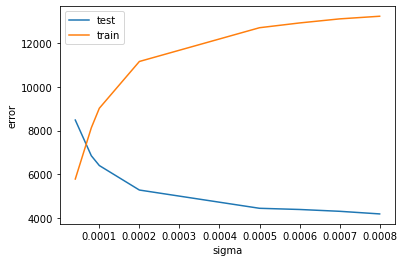

In [12]:
sig = [0.00004,0.00008,0.0001,0.0002,0.0005,0.0006, 0.0007, 0.0008]
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)
pred=[]
errors_test=[]
errors_train=[]
for s in sig:
    N = Nadaraya(kernel=uni, sigma=s)
    N.fit(geo_train,notes_train)
    pred_test= (np.array(N.predict(geo_test)))
    
    errors_test.append(error(pred_test,notes_test))
    pred_train =(np.array(N.predict(geo_train)))
    errors_train.append(error(pred_train,notes_train))
    
plt.plot(sig,errors_test,label='test')
plt.plot(sig,errors_train,label='train')
plt.xlabel('sigma')
plt.ylabel('error')
plt.legend()
plt.show()
plt.close()

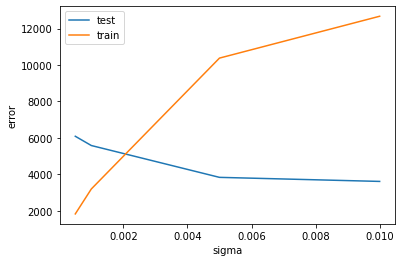

In [13]:
sig = [0.0005,0.001,0.005,0.01]
geo_train, geo_test, notes_train, notes_test = train_test_split(geo_mat, notes, test_size=0.2, random_state=0)
pred=[]
errors_test=[]
errors_train=[]
for s in sig:
    N = Nadaraya(kernel=gaussian, sigma=s)
    N.fit(geo_train,notes_train)
    pred_test= (np.array(N.predict(geo_test)))
    
    errors_test.append(error(pred_test,notes_test))
    pred_train =(np.array(N.predict(geo_train)))
    errors_train.append(error(pred_train,notes_train))
    
plt.plot(sig,errors_test,label='test')
plt.plot(sig,errors_train,label='train')
plt.xlabel('sigma')
plt.ylabel('error')
plt.legend()
plt.show()
plt.close()

In [ ]:
# train meilleur si sigma petit alors que test meilleur si sigma grand assez logique
# plus sigma est petit plus on colle au données apprise
#quand sigma augmente fortement, cela donne la meme note pour tous les individus (note autour de 3)
# deplus il est peu probable que les notes d'un bar/boite de nuit soit réellement corrélé au quartier